In [1]:
import torch
import cvxpy as cp
import numpy as np
import scipy.sparse as spa
from cvxpylayers.torch import CvxpyLayer
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
np.random.seed(0)

# generate problem data
n = 4   # nodes
k = 2   # suppliers (with prices p)
c = 2   # retail (with demand d)
m = 8   # links

supply_links = [0, 1]
retail_links = [6, 7]
internode_links = [2, 3, 4, 5]

# Incidence matrices (nodes x links)
A_in = np.array([[1, 0, 0, 0, 0, 0, 0, 0],   # 1 (supply)
                 [0, 1, 0, 0, 0, 0, 0, 0],   # 2 (supply)
                 [0, 0, 1, 0, 0, 1, 0, 0],   # 3 (retail)
                 [0, 0, 0, 1, 1, 0, 0, 0],   # 4 (retail)
                 ])

A_out = np.array([[0, 0, 1, 1, 0, 0, 0, 0],   # 1 (supply)
                  [0, 0, 0, 0, 1, 0, 0, 0],   # 2 (supply)
                  [0, 0, 0, 0, 0, 0, 1, 0],   # 3 (retail)
                  [0, 0, 0, 0, 0, 1, 0, 1],   # 4 (retail)
                  ])

# Prices
mu_p = torch.tensor([0, 0.1]).double()
sigma_p = torch.tensor([0.2, 0.2]).double()
mean_p = torch.exp(mu_p + sigma_p ** 2 /2).double().view(k, 1)
var_p = (torch.exp(sigma_p ** 2) - 1) * torch.exp(2 * mean_p + sigma_p ** 2)

# Demands
mu_d = torch.tensor([0.0, 0.4]).double()
sigma_d = torch.tensor([0.2, 0.2]).double()
mean_d = torch.exp(mu_d + sigma_d ** 2 /2).double().view(c, 1)
var_d = (torch.exp(sigma_d ** 2) - 1) * torch.exp(2 * mean_d + sigma_d ** 2)

# Uncertainty distribution (prices and demands)
w_dist = torch.distributions.log_normal.LogNormal(torch.cat([mu_p, mu_d], 0), 
                                                  torch.cat([sigma_p, sigma_d], 0))

# Capacities
h_max = 3. # Maximum capacity in every node
u_max = 2. # Link flow capacity

# Storage cost parameters, W(x) = alpha'x + beta'x^2 + gamma
alpha = 0.01
beta = 0.01

# Transportation cost parameters
tau = 0.05 * np.ones((m - k - c, 1))
tau_th = torch.tensor(tau, dtype=torch.double)
r = 1.3 * np.ones((k, 1))
r_th = torch.tensor(r, dtype=torch.double)

In [3]:
print(w_dist.sample())
print(mean_p)
print(var_p)
print(mean_d)
print(var_d)

tensor([1.0703, 0.9826, 1.3146, 1.1100], dtype=torch.float64)
tensor([[1.0202],
        [1.1275]], dtype=torch.float64)
tensor([[0.3268, 0.3268],
        [0.4050, 0.4050]], dtype=torch.float64)
tensor([[1.0202],
        [1.5220]], dtype=torch.float64)
tensor([[0.3268, 0.3268],
        [0.8915, 0.8915]], dtype=torch.float64)


In [4]:
# Define linear dynamics
# x = (h, p^{wh}, d) 
# u = u
# w = (p^{wh}, d)
# x_{t+1} = Ax_{t} + Bu_{t} + w
A_d = np.bmat([[np.eye(n), np.zeros((n, k+c))],
              [np.zeros((k+c, n)), np.zeros((k+c, k+c))]])
A_d_th = torch.tensor(A_d, dtype=torch.double)
B_d = np.vstack([A_in - A_out,
                 np.zeros((k+c, m))])
B_d_th = torch.tensor(B_d, dtype=torch.double)
n_x, n_u = B_d.shape

In [5]:
# Setup policy
# Parameters
P_sqrt = cp.Parameter((n, n)) # 4x4
q = cp.Parameter((n, 1)) # 4x1
x = cp.Parameter((n_x, 1)) # 8x1
h, p, d = x[:n], x[n:n+k], x[n+k:]

# Variables
u = cp.Variable((n_u, 1))
h_next = cp.Variable((n, 1))

# Cvxpy Layer
stage_cost = cp.vstack([p, tau, -r]).T @ u
next_stage_cost = cp.sum_squares(P_sqrt @ h_next) + q.T @ h_next
constraints = [h_next == h + (A_in - A_out) @ u, 
               h_next <= h_max,  
               0 <= u, u <= u_max,
               A_out @ u <= h, u[retail_links] <= d,
              ]
prob = cp.Problem(cp.Minimize(stage_cost + next_stage_cost), constraints)
policy = CvxpyLayer(prob, [x, P_sqrt, q], [u])

In [29]:
def stage_cost(x, u):
    assert x.shape[0] == u.shape[0]
    batch_size = x.shape[0]
    r_batch = r_th.repeat(batch_size, 1, 1)
    tau_batch = tau_th.repeat(batch_size, 1, 1)
    
    h, p, dh = x[:,:n], x[:, n:n+k], x[:, n+k:]
    
    m = len(u)    
    
    # Selling + buying + shipping cost
    s_vec = torch.cat([p, tau_batch, -r_batch], 1).double()
    S = torch.bmm(s_vec.transpose(1, 2), u)
    H = alpha * h + beta * (h ** 2)  # Storage cost
        
    return torch.sum(S, 1) + torch.sum(H, 1)

def simulate(x, u):
    assert x.shape[0] == u.shape[0]
    batch_size = x.shape[0]

    A_batch = A_d_th.repeat(batch_size, 1, 1)
    B_batch = B_d_th.repeat(batch_size, 1, 1)
    
    zer = torch.zeros(batch_size, n, 1).double()
    w = w_dist.sample((batch_size,)).double().view((batch_size, k + c, 1))
    w_batch = torch.cat([zer, w], 1).double()
    
    return torch.bmm(A_batch, x) + torch.bmm(B_batch, u) + w_batch

    
def loss(policy, params, time_horizon, batch_size=1, seed=None):
    P_sqrt, q = params
    if seed is not None:
        torch.manual_seed(seed)
        
    # Batchify input
    x_b_0 = h_max * torch.rand(batch_size, n, 1).double()
    w_0 = w_dist.sample((batch_size,)).double().view((batch_size, k+c, 1))
    x_batch = torch.cat([x_b_0, w_0], 1).double()

    # Repeat parameter values
    P_sqrt_batch = P_sqrt.repeat(batch_size, 1, 1)
    q_batch = q.repeat(batch_size, 1, 1)

    cost = 0.0
    x_t = x_batch
    x_hist = [x_batch]
    u_hist = []
    for t in range(time_horizon):
        u_t = policy(x_t, P_sqrt_batch, q_batch, solver_args={"acceleration_lookback": 0})[0]
        x_t = simulate(x_t, u_t) 
        cost += stage_cost(x_t, u_t).mean() / time_horizon
        x_hist.append(x_t)
        u_hist.append(u_t)
        
    return cost, x_hist, u_hist

def monte_carlo(policy, params, time_horizon, batch_size=1, trials=10, seed=None):
    if seed is not None:
        torch.manual_seed(seed)
    results = []
    x = []
    u = []
    
    for i in range(trials):
        cost, x_hist, u_hist = loss(policy, params, time_horizon, batch_size=batch_size, seed=seed)
        results.append(cost.item())
        x.append(x_hist)
        u.append(u_hist)
    return results, x, u

In [30]:
def train(policy, params, time_horizon, lr, epochs, batch_size):
    opt = torch.optim.SGD(params, lr=lr)
    val_costs = []
    best_params = []
    # updating without gradient
    
    for epoch in range(epochs):
        with torch.no_grad():
            val_cost_mc, x_behav, u_behav = monte_carlo(policy, params, time_horizon, 1, trials=10, seed=0)
            val_cost = np.mean(val_cost_mc)
            val_costs.append(val_cost)

        torch.manual_seed(epoch)
        opt.zero_grad()
        cost, _, _,  = loss(policy, params, time_horizon, batch_size, seed=epoch+1)
        cost.backward()
        print("epoch %d, valid %.4e" % (epoch, val_cost))         
        # TODO: Print gradient norm (possibly clip it)
        # torch.nn.utils.clip_grad_norm_(params, 1)
#         for p in params:
#             print(p.grad.data.norm(2).item())
        opt.step()
#         scheduler.step(val_cost)        
    return val_costs, [np.array(p.detach().numpy()) for p in params], x_behav, u_behav

In [31]:
def loss_aggregate(policy, param_set, time_horizon, batch_size=1, seed=None):
    costs = []
    for param in param_set:
        costs.append(loss(policy, params, time_horizon, batch_size=1, seed=None)[0])

    best_zetas = np.argsort(costs) # update to return parameters
    return best_zetas

In [32]:
# Perform training
time_horizon = 10
epochs = 200
batch_size = 5
lr = 0.05

# Initialize value function V(x) = x'Px + q'x
# centered at h_max/2 (between 0 and h_max) of each node
torch.manual_seed(0)
P_sqrt = torch.eye(n, requires_grad=True, dtype=torch.double)
q = -h_max * torch.ones(n, 1, dtype=torch.double)
# P_sqrt = torch.zeros(n, n).double()
# q = torch.zeros((n, 1)).double()
q.requires_grad_(True)
params = [P_sqrt, q]

# Baseline
P_sqrt_baseline = torch.eye(n, dtype=torch.double)
q_baseline = -h_max * torch.ones(n, 1, dtype=torch.double)
# P_sqrt_baseline = torch.zeros(n, n).double()
# q_baseline = torch.zeros((n, 1)).double()
baseline_params = [P_sqrt_baseline, q_baseline]
baseline_costs, x_behav_bl, u_behav_bl = monte_carlo(policy, baseline_params, time_horizon, batch_size=1, trials=10, seed=0)
baseline_cost = np.mean(baseline_costs)
print("Baseline cost: ", baseline_cost)

print("Perform training")
val_cost, params, x_behav, u_behav = train(policy, params, time_horizon, lr, epochs, batch_size)
print("Final cost: ", val_cost[-1])

improvement = 100 * np.abs(baseline_cost - val_cost[-1])/np.abs(baseline_cost)
print("Performance improvement: %.2f %% over baseline cost" %  improvement)

# Store final values
P_sqrt_train = P_sqrt.detach().numpy()
q_train = q.detach().numpy()

Baseline cost:  -0.4186972256870515
Perform training
epoch 0, valid -4.1870e-01
epoch 1, valid -4.3153e-01
epoch 2, valid -4.3953e-01
epoch 3, valid -4.4775e-01
epoch 4, valid -4.5500e-01
epoch 5, valid -4.5873e-01
epoch 6, valid -4.6325e-01
epoch 7, valid -4.6693e-01


/Users/qasimwani/opt/anaconda3/lib/python3.7/site-packages/diffcp/cone_program.py:282: UserWarning: Solved/Inaccurate.
  warnings.warn("Solved/Inaccurate.")


epoch 8, valid -4.7074e-01
epoch 9, valid -4.7343e-01
epoch 10, valid -4.7677e-01
epoch 11, valid -4.7715e-01
epoch 12, valid -4.7955e-01
epoch 13, valid -4.7835e-01
epoch 14, valid -4.7947e-01
epoch 15, valid -4.8181e-01
epoch 16, valid -4.8195e-01
epoch 17, valid -4.8432e-01
epoch 18, valid -4.8424e-01
epoch 19, valid -4.8378e-01
epoch 20, valid -4.8588e-01
epoch 21, valid -4.8703e-01
epoch 22, valid -4.8765e-01
epoch 23, valid -4.8866e-01
epoch 24, valid -4.8799e-01
epoch 25, valid -4.8897e-01
epoch 26, valid -4.9042e-01
epoch 27, valid -4.9007e-01
epoch 28, valid -4.8994e-01
epoch 29, valid -4.9170e-01
epoch 30, valid -4.9186e-01
epoch 31, valid -4.9244e-01
epoch 32, valid -4.9314e-01
epoch 33, valid -4.9292e-01
epoch 34, valid -4.9280e-01
epoch 35, valid -4.9304e-01
epoch 36, valid -4.9366e-01
epoch 37, valid -4.9436e-01
epoch 38, valid -4.9459e-01
epoch 39, valid -4.9517e-01
epoch 40, valid -4.9552e-01
epoch 41, valid -4.9585e-01
epoch 42, valid -4.9660e-01
epoch 43, valid -4.971

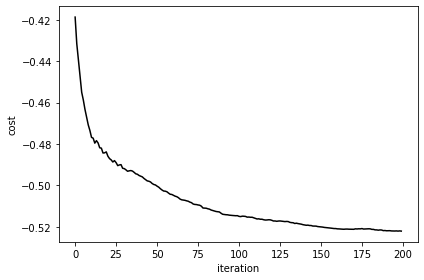

In [12]:
plt.plot(val_cost, c='k', label="Loss")
plt.xlabel('iteration')
plt.ylabel('cost')
plt.tight_layout()
plt.savefig("supply_chain_training.pdf")
plt.show()

In [28]:
x_behav[-1]

[tensor([[[1.4888],
          [2.3047],
          [0.2654],
          [0.3961],
          [0.6468],
          [1.2382],
          [0.8050],
          [1.1278]]], dtype=torch.float64),
 tensor([[[1.1766],
          [1.1766],
          [1.1516],
          [1.1516],
          [1.0840],
          [1.3068],
          [0.8660],
          [1.3762]]], dtype=torch.float64)]